In [22]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [24]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [25]:
#check is there any nan value
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<Axes: ylabel='Density'>

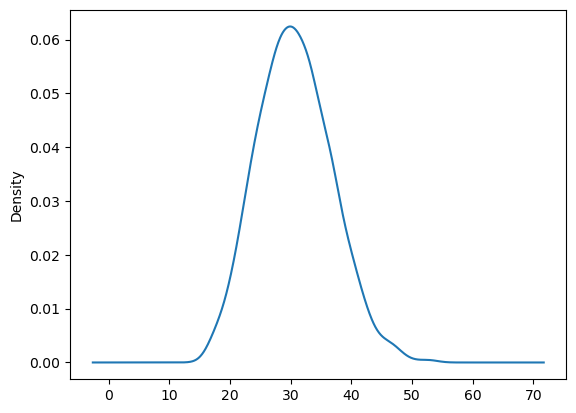

In [26]:
#Examining the distribution of Bmi (Body Mass Index) -> kde means kernel density estimation
df['bmi'].plot(kind='kde')

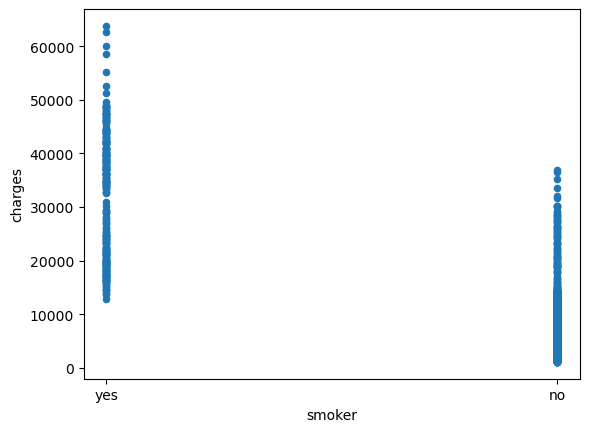

In [28]:
df.plot(
   x='smoker', 
   y='charges', 
   kind='scatter'
)

plt.show()
#it shows us to smokers have more charges than non-smokers

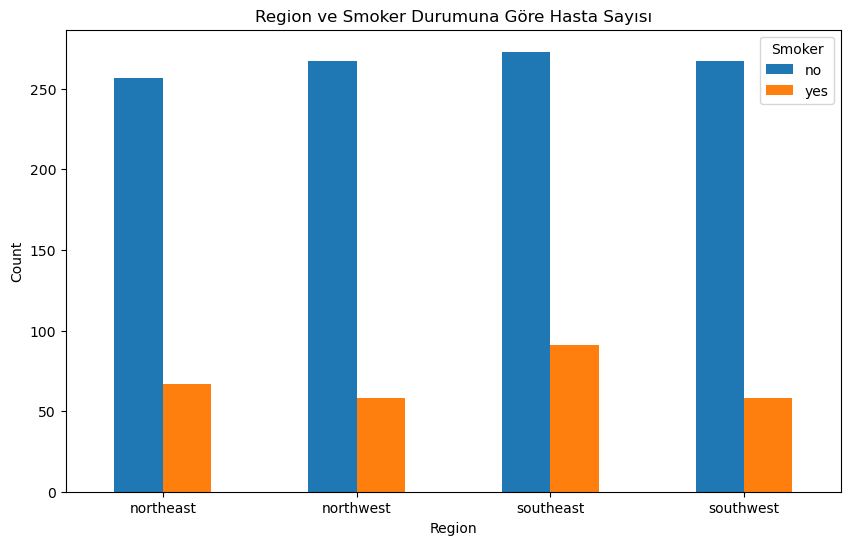

In [29]:
grouped = df.groupby(['region', 'smoker']).size().reset_index(name='count')
pivot_df = grouped.pivot(index='region', columns='smoker', values='count')
pivot_df.plot(kind='bar',figsize=(10, 6))

plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Region ve Smoker Durumuna Göre Hasta Sayısı')
plt.xticks(rotation=0)  

plt.legend(title='Smoker')
plt.show()

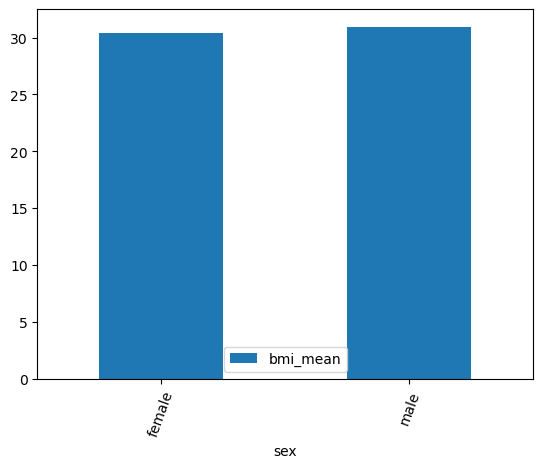

In [30]:
df.groupby(['sex'])['bmi'].mean().reset_index(name='bmi_mean').plot.bar(x="sex", y="bmi_mean", rot=70);

plt.show(block=True);
#it shows bmi values are usually same between male and female people

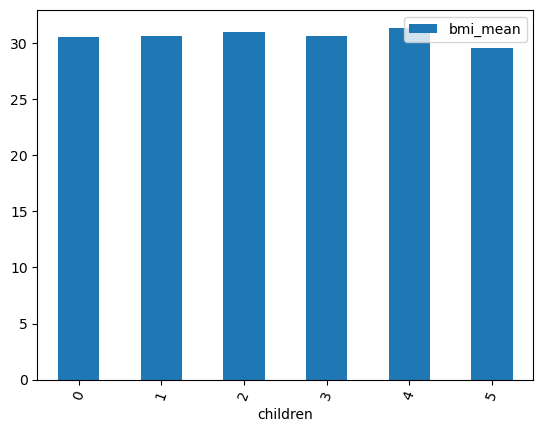

In [31]:
df.groupby(['children'])['bmi'].mean().reset_index(name='bmi_mean').plot.bar(x="children", y="bmi_mean", rot=70);

plt.show(block=True);
#there is no relation between number of children and bmi index

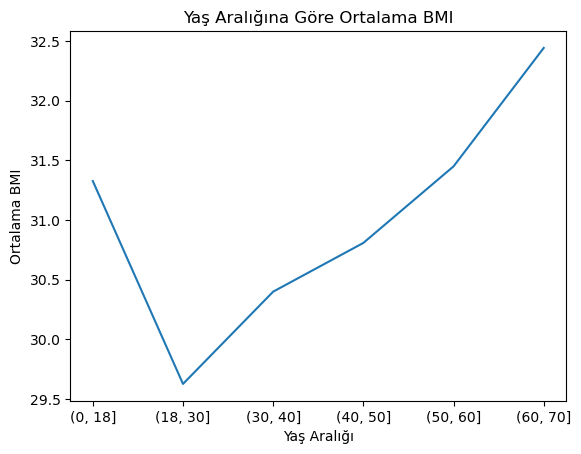

In [32]:
age_bins = [0,18,30,40,50,60,70]

df['age_groups'] = pd.cut(df['age'], bins=age_bins)
result = df.groupby('age_groups')['bmi'].mean()

result.plot(kind='line', rot=0)
plt.xlabel('Yaş Aralığı')
plt.ylabel('Ortalama BMI')
plt.title('Yaş Aralığına Göre Ortalama BMI')
plt.show()
#we can see from chart that bmi values of people is usually increases with time except teenagers.

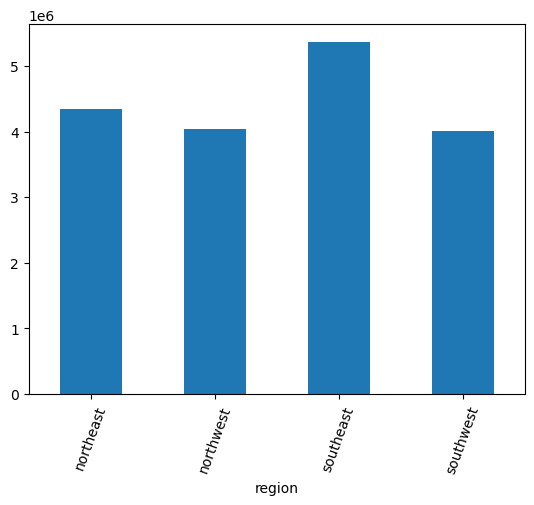

In [33]:
df.groupby('region')['charges'].sum().plot.bar(x="region", y="charges", rot=70);

plt.show(block=True);
 
#bar plot shows us to region with the most child is southeast

In [34]:
dummies = pd.get_dummies(df[['region', 'smoker', 'sex']])


dummies = pd.concat([df[['age', 'bmi', 'children', 'charges']], dummies], axis=1)
dummies.drop(['smoker_no', 'sex_female'], axis = 1, inplace = True)
dummies.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,smoker_yes,sex_male
0,19,27.900,0,16884.92400,0,0,0,1,1,0
1,18,33.770,1,1725.55230,0,0,1,0,0,1
2,28,33.000,3,4449.46200,0,0,1,0,0,1
3,33,22.705,0,21984.47061,0,1,0,0,0,1
4,32,28.880,0,3866.85520,0,1,0,0,0,1


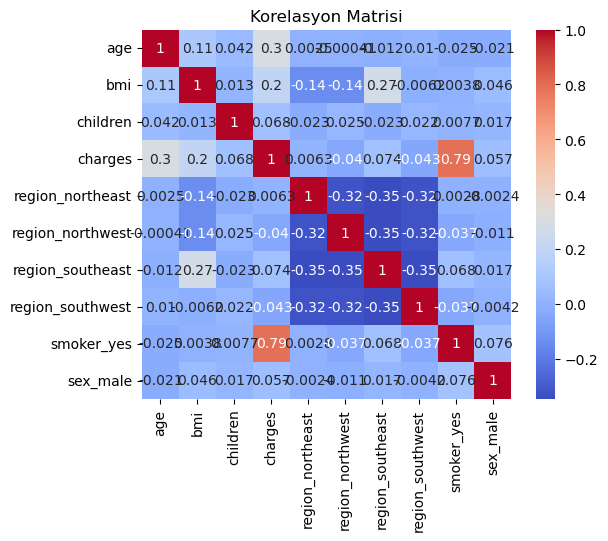

In [35]:
#Examining the relations between features
correlation_matrix = dummies.corr()

# Plotting correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

plt.title("Korelasyon Matrisi")
plt.show()

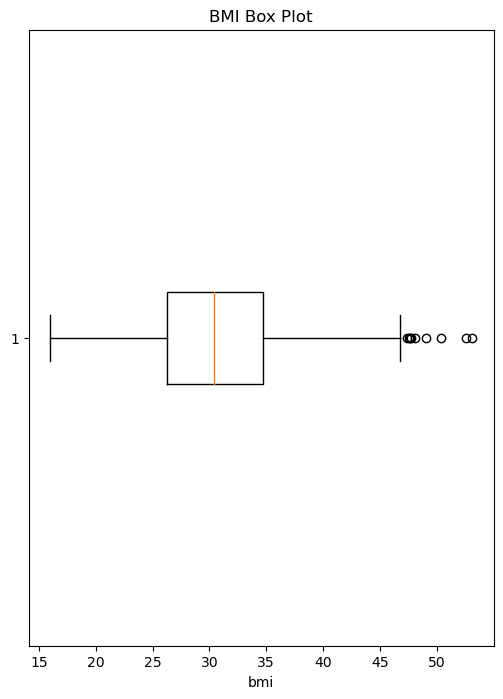

In [36]:
plt.figure(figsize=(6, 8)) 
plt.boxplot(df['bmi'], vert=False)  
plt.xlabel('bmi')
plt.title('BMI Box Plot')
plt.show()
#we see that outlier points when the bmi values above 45

In [37]:
Q1 = dummies['bmi'].quantile(0.25)
Q3 = dummies['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dummies['bmi'] = dummies['bmi'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))


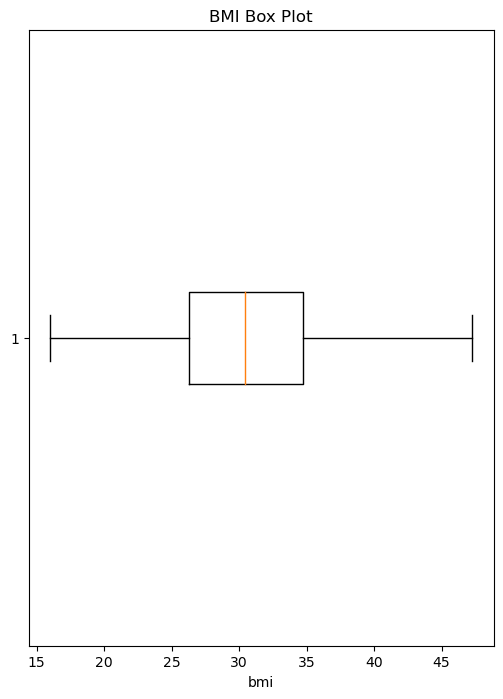

In [38]:
plt.figure(figsize=(6, 8)) 
plt.boxplot(dummies['bmi'], vert=False) 
plt.xlabel('bmi')
plt.title('BMI Box Plot')
plt.show()
#outlier changed with upper_bound value and lower_bound value using IQR technique

In [39]:
X = dummies.drop('charges', axis = 1)
y = dummies['charges']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [41]:
#PCA 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=8)

principalComponents = pca.fit_transform(X_train)

principalDf = pd.DataFrame(data = principalComponents )

In [61]:
def calculate_scores(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    print("MAE:", mae)
    
    mse = mean_squared_error(y_true, y_pred)
    print("MSE:", mse)
    
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    
    r2 = r2_score(y_true, y_pred)
    print("R-squared:", r2)


In [60]:
def calculate_scores_cv(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

In [93]:
# K-Fold Cross-Validation
def cross_val(model, k , X, y):
    scores = []
    cv = KFold(n_splits=k, random_state = 42, shuffle=True)
    mae_total = 0
    mse_total = 0
    rmse_total = 0
    r2_total = 0
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae, mse, rmse, r2 = calculate_scores_cv(y_test, y_pred)
        mae_total += mae
        mse_total += mse
        rmse_total += rmse
        r2_total += r2
    print(model)
    print(f'average mae: {mae_total/k}')
    print(f'average mse: {mse_total/k}')
    print(f'average rmse: {rmse_total/k}')
    print(f'average r2: {r2_total/k}')
        

In [95]:
models = [LinearRegression()]
models.append(RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]))
models.append(linear_model.Lasso(alpha=0.1))
models.append(SVR(kernel='rbf'))
models.append(DecisionTreeRegressor(random_state=0))
models.append(RandomForestRegressor(max_depth=2, random_state=0))
models.append(XGBRegressor())
for model in models:
    cross_val(model, 10, X, y)

LinearRegression()
average mae: 4208.3824718863725
average mse: 37002569.85917638
average rmse: 6069.194030422184
average r2: 0.7391968511071687
RidgeCV(alphas=[0.001, 0.01, 0.1, 1])
average mae: 4209.243238193105
average mse: 37002293.9002437
average rmse: 6069.185476045018
average r2: 0.7392053888766228
Lasso(alpha=0.1)
average mae: 4208.3969724640665
average mse: 37002426.737098634
average rmse: 6069.183084383802
average r2: 0.7391981520518316
SVR()
average mae: 8313.286206558452
average mse: 161702968.7094508
average rmse: 12662.866202610361
average r2: -0.1060075762089571
DecisionTreeRegressor(random_state=0)
average mae: 3174.8231560817358
average mse: 44548087.65417864
average rmse: 6664.698950953466
average r2: 0.6889064875507722
RandomForestRegressor(max_depth=2, random_state=0)
average mae: 3275.7804446360806
average mse: 25269925.419378225
average rmse: 5010.635725492616
average r2: 0.822302104071172
XGBRegressor(base_score=None, booster=None, callbacks=None,
             co

In [150]:
model = LinearRegression()
y_pred = model.fit(X_train, y_train).predict(X_test)
calculate_scores(y_test, y_pred)

MAE: 4181.194473753654
MSE: 33596915.85136148
RMSE: 5796.284659276275
R-squared: 0.7835929767120722


In [164]:
model = LinearRegression()
y_pred = model.fit(principalDf, y_train).predict(pca.transform(X_test))
calculate_scores(y_test, y_pred)
#In PCA, the maximum value was obtained only when n was 8. At other values, the results are very low.

MAE: 4181.194473753649
MSE: 33596915.851361476
RMSE: 5796.284659276274
R-squared: 0.7835929767120722


# **When the results were evaluated, the random forest regressor was chosen as the best model.**

In [165]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("En İyi Hiperparametreler:", grid_search.best_params_)
print("En İyi Skor (Negatif MSE):", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


En İyi Hiperparametreler: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
En İyi Skor (Negatif MSE): -22272527.850775372


In [47]:
model = RandomForestRegressor(max_depth = 10, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 300)
y_pred = model.fit(X_train, y_train).predict(X_test)
calculate_scores(y_test, y_pred)

MAE: 2430.9907219495594
MSE: 18907265.826288182
RMSE: 4348.248592972598
R-squared: 0.8782130736617964


In [98]:
model = RandomForestRegressor(max_depth = 10, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 300)
y_pred = model.fit(principalDf, y_train).predict(pca.transform(X_test))
calculate_scores(y_test, y_pred)
#training results for pca applied training set. Also this results shows the pca doesn't provide benefits with this dataset

MAE: 3382.63373289371
MSE: 29837408.942345005
RMSE: 5462.362944948368
R-squared: 0.8078090000759455
